NNHIỆM VỤ BỔ SUNG: Thu thập dữ liệu đánh giá về manulife trên google maps: https://www.google.com/maps/place/B%E1%BA%A3o+Hi%E1%BB%83m+Manulife/@10.7814739,106.6906709,15.49z/data=!4m10!1m2!2m1!1smanulife!3m6!1s0x317528d318cfb18b:0xba954bd27cb9e831!8m2!3d10.7811083!4d106.6970667!15sCghtYW51bGlmZSIDiAEBWgoiCG1hbnVsaWZlkgERaW5zdXJhbmNlX2NvbXBhbnngAQA!16s%2Fg%2F11c38t5mw5?hl=vi&entry=ttu&g_ep=EgoyMDI0MDkyNS4wIKXMDSoASAFQAw%3D%3D

Xây dựng mô hình phân tích quan điểm đánh giá của người dùng về manulife.


In [52]:
import numpy as np
import pandas as pd
import os

In [53]:
!pip install -q py_vncorenlp stop_words underthesea

In [54]:
import re
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
stop_words_vi = get_stop_words('vi')
import py_vncorenlp
from tqdm import tqdm
import networkx as nx
from collections import Counter

import pandas as pd
from nltk import ngrams
from gensim.models import Word2Vec
from wordcloud import WordCloud

import sys
import importlib
import collections
import itertools
import matplotlib.pyplot as plt
import logging

In [55]:
data = pd.read_csv('/content/DataCrawl.csv')
if 'Content' in data.columns:
    # Thay thế các giá trị NaN trong cột 'Review Text' bằng chuỗi rỗng
    data['Content'] = data['Content'].fillna("")

In [56]:
data

,Reviewer,Content,Date,Stars,Local Guide,Likes,Label
0,Tung Anh Yogi,Mọi người thân thiện khi Ci Yoga Therapy đến l...,4 tuần trước,5 sao,2 bài đánh giá · 2 ảnh,0,Tích cực
1,Cẩm Thuy,"Hợp đồng không được chăm sóc, không có nhân vi...",3 tuần trước,1 sao,2 bài đánh giá · 3 ảnh,0,Tiêu cực
2,Hiền Trần,"Bạn bè, người thân nói mình mua bảo hiểm không...",2 tháng trước,1 sao,Local Guide · 25 bài đánh giá · 28 ảnh,0,Tiêu cực
3,Tuấn Anh Nguyễn,Manulife ủy quyền cho công ty này giải quyết c...,4 tháng trước,1 sao,16 bài đánh giá · 17 ảnh,2,Tiêu cực
4,Quyen Dinh,Tôi cần nhân viên giải quyết về quyền lợi của ...,3 tháng trước,1 sao,1 bài đánh giá · 8 ảnh,2,Tiêu cực
5,Clever Kids,Manulife là một công ty bảo hiểm Nuoc ngoài đầ...,5 năm trước,5 sao,Local Guide · 14 bài đánh giá · 510 ảnh,2,Tích cực
6,Diep Ngoc,"Văn phòng đep, rông rãi, nhân vien nhiet tinh ...",5 năm trước,5 sao,1 bài đánh giá · 4 ảnh,1,Tích cực
7,QUANG PRO - Review tất tần tật,"Văn phòng sạch đẹp, nhân viên lịch sự và văn h...",3 năm trước,5 sao,Local Guide · 144 bài đánh giá · 117 ảnh,0,Tích cực
8,Tran Quoc Cuong,Công ty tài chính chuyên nghiêp Quy tụ nhiều b...,6 năm trước,5 sao,Local Guide · 57 bài đánh giá · 56 ảnh,0,Tích cực
9,Thị Hiền Đào,Gọi điện ko nghe máy tư vấn ko niềm nỡ,5 tháng trước,1 sao,1 bài đánh giá · 1 ảnh,0,Tiêu cực


In [6]:
import re
import string
from underthesea import word_tokenize
import pandas as pd

vietnamese_stopwords_file = '/content/vietnamese-stopwords.txt'

# Đọc các từ dừng tiếng Việt từ file
with open(vietnamese_stopwords_file, 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

# Thêm từ "cho" và "và" vào danh sách từ dừng
# vietnamese_stopwords.extend(["cho", "và","khi"])

def preprocess_text(text):

    # Chuyển văn bản thành chữ thường
    text = text.lower()

    # Loại bỏ URL
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r" ", text)

    # Loại bỏ thẻ HTML
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # Loại bỏ dấu câu và số
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    text = " ".join(text.split())

    # Loại bỏ emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    # Tokenize text sử dụng underthesea với định dạng "text"
    tokens = word_tokenize(text, format="text")

    # Loại bỏ các từ dừng tiếng Việt
    filtered_tokens = [word for word in tokens.split("_") if word.lower() not in vietnamese_stopwords and word not in ["cho", "và", "khi"]]

    # Kết hợp lại các từ đã lọc với dấu gạch dưới
    return "_".join(filtered_tokens)

In [57]:
data['processed_content'] = data['Content'].apply(preprocess_text)
data.head(5)

,Reviewer,Content,Date,Stars,Local Guide,Likes,Label,processed_content
0,Tung Anh Yogi,Mọi người thân thiện khi Ci Yoga Therapy đến l...,4 tuần trước,5 sao,2 bài đánh giá · 2 ảnh,0,Tích cực,thân_thiện khi ci yoga therapy đến làm worksho...
1,Cẩm Thuy,"Hợp đồng không được chăm sóc, không có nhân vi...",3 tuần trước,1 sao,2 bài đánh giá · 3 ảnh,0,Tiêu cực,hợp_đồng không được chăm_sóc không có nhân_viê...
2,Hiền Trần,"Bạn bè, người thân nói mình mua bảo hiểm không...",2 tháng trước,1 sao,Local Guide · 25 bài đánh giá · 28 ảnh,0,Tiêu cực,bè người_thân nói mình mua bảo_hiểm không có l...
3,Tuấn Anh Nguyễn,Manulife ủy quyền cho công ty này giải quyết c...,4 tháng trước,1 sao,16 bài đánh giá · 17 ảnh,2,Tiêu cực,manulife ủy quyền cho công_ty này giải_quyết c...
4,Quyen Dinh,Tôi cần nhân viên giải quyết về quyền lợi của ...,3 tháng trước,1 sao,1 bài đánh giá · 8 ảnh,2,Tiêu cực,tôi cần nhân_viên giải_quyết về quyền_lợi của ...


In [58]:
from transformers import AutoTokenizer
# Khởi tạo tokenizer từ mô hình bạn chọn
PRETRAINED_MODEL = 'mr4/phobert-base-vi-sentiment-analysis'  # Ví dụ về tên mô hình
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

# Áp dụng tokenizer cho cột 'content' của DataFrame
data['tokens'] = data['Content'].apply(lambda x: tokenizer.encode(x))
data['decoded'] = data['tokens'].apply(lambda x: tokenizer.decode(x))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [59]:
data[['Content', 'tokens', 'decoded']].head(5)

,Content,tokens,decoded
0,Mọi người thân thiện khi Ci Yoga Therapy đến l...,"[0, 2115, 18, 1182, 5320, 26, 1070, 1111, 1602...",<s> Mọi người thân thiện khi Ci Yoga Therapy đ...
1,"Hợp đồng không được chăm sóc, không có nhân vi...","[0, 7765, 80, 17, 11, 5115, 49850, 1395, 4, 17...","<s> Hợp đồng không được chăm sóc, không có nhâ..."
2,"Bạn bè, người thân nói mình mua bảo hiểm không...","[0, 970, 1388, 9367, 4, 18, 1182, 96, 68, 188,...","<s> Bạn bè, người thân nói mình mua bảo hiểm k..."
3,Manulife ủy quyền cho công ty này giải quyết c...,"[0, 19881, 21022, 21356, 1231, 493, 13, 675, 6...",<s> Manulife ủy quyền cho công ty này giải quy...
4,Tôi cần nhân viên giải quyết về quyền lợi của ...,"[0, 218, 115, 1362, 1430, 248, 4436, 28, 493, ...",<s> Tôi cần nhân viên giải quyết về quyền lợi ...


Content Analysis

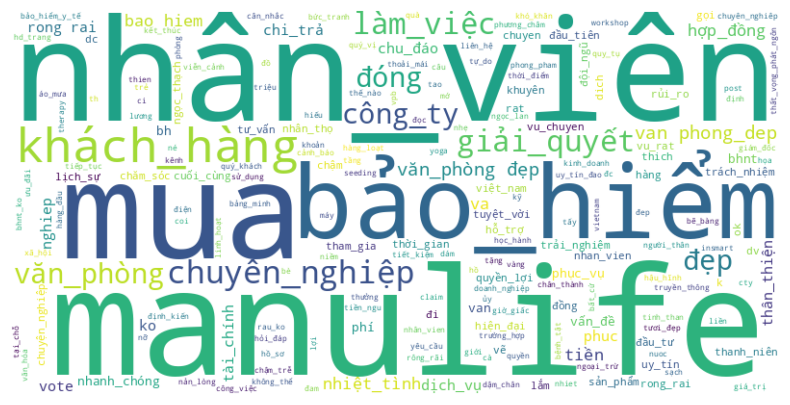

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Kết hợp tất cả các nội dung đã xử lý thành một chuỗi
all_text = ' '.join(data['processed_content'])

# Tạo word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None, stopwords=vietnamese_stopwords).generate(all_text)

# Hiển thị word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


[('manulife', 14), ('nhân_viên', 13), ('mua', 12), ('bảo_hiểm', 12), ('văn_phòng', 12), ('đẹp', 12), ('khách_hàng', 9), ('van', 9), ('chuyên_nghiệp', 8), ('giải_quyết', 7)]


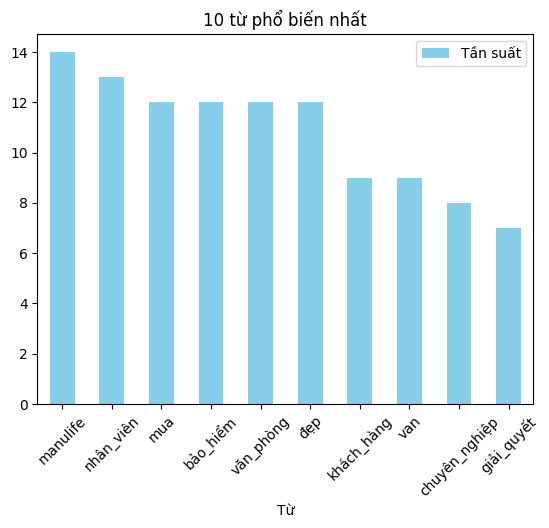

In [61]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Gộp tất cả các từ lại sau khi xử lý dữ liệu
all_words = ' '.join(data['processed_content']).split()

# Loại bỏ các từ dừng
filtered_words = [word for word in all_words if word not in vietnamese_stopwords]

# Đếm tần suất xuất hiện của từng từ
word_counts = Counter(filtered_words)

# Lấy 10 từ phổ biến nhất
common_words = word_counts.most_common(10)
print(common_words)

# Vẽ biểu đồ từ phổ biến
pd.DataFrame(common_words, columns=['Từ', 'Tần suất']).plot(kind='bar', x='Từ', y='Tần suất', color='skyblue', title='10 từ phổ biến nhất')
plt.xticks(rotation=45)
plt.show()

Cặp từ: 'văn_phòng đẹp' xuất hiện 6 lần.
Cặp từ: 'van phong_dep' xuất hiện 6 lần.
Cặp từ: 'bao hiem' xuất hiện 5 lần.
Cặp từ: 'rong rai' xuất hiện 4 lần.
Cặp từ: 'đóng phí' xuất hiện 3 lần.
Cặp từ: 'mua bhnt' xuất hiện 3 lần.
Cặp từ: 'công_ty bảo_hiểm' xuất hiện 3 lần.
Cặp từ: 'hiem manulife' xuất hiện 3 lần.
Cặp từ: 'phong_dep va' xuất hiện 3 lần.
Cặp từ: 'nhân_viên hỗ_trợ' xuất hiện 2 lần.


<Figure size 1000x600 with 0 Axes>

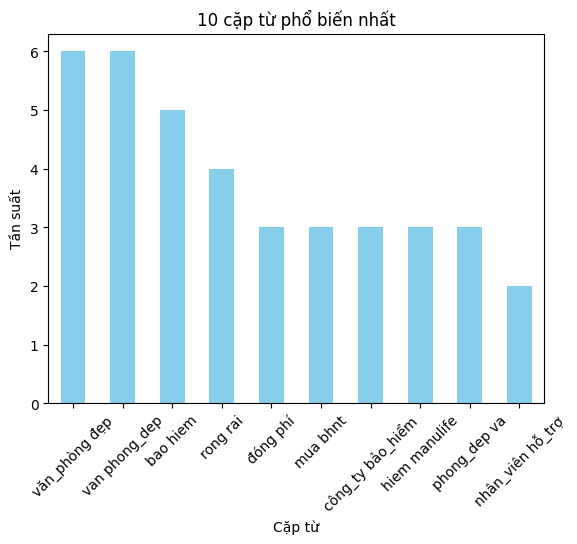

In [62]:
# Tạo bigrams từ tất cả các từ đã xử lý
all_words = ' '.join(data['processed_content']).split()
filtered_words = [word for word in all_words if word not in vietnamese_stopwords]
bigrams = list(ngrams(filtered_words, 2))

# Đếm tần suất các bigrams
bigram_counts = Counter(bigrams)

# Lấy 10 cặp từ (bigrams) phổ biến nhất
common_bigrams = bigram_counts.most_common(10)

# Tạo DataFrame cho các cặp từ và tần suất của chúng
bigram_df = pd.DataFrame(common_bigrams, columns=['Cặp từ', 'Tần suất'])
bigram_df['Cặp từ'] = bigram_df['Cặp từ'].apply(lambda x: ' '.join(x))  # Chuyển tuple thành chuỗi

# In số lượng xuất hiện của các cặp từ
for index, row in bigram_df.iterrows():
    print(f"Cặp từ: '{row['Cặp từ']}' xuất hiện {row['Tần suất']} lần.")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bigram_df.plot(kind='bar', x='Cặp từ', y='Tần suất', color='skyblue', legend=False, title='10 cặp từ phổ biến nhất')
plt.xlabel('Cặp từ')
plt.ylabel('Tần suất')
plt.xticks(rotation=45)
plt.show()


In [63]:
data.head(5)

,Reviewer,Content,Date,Stars,Local Guide,Likes,Label,processed_content,tokens,decoded
0,Tung Anh Yogi,Mọi người thân thiện khi Ci Yoga Therapy đến l...,4 tuần trước,5 sao,2 bài đánh giá · 2 ảnh,0,Tích cực,thân_thiện khi ci yoga therapy đến làm worksho...,"[0, 2115, 18, 1182, 5320, 26, 1070, 1111, 1602...",<s> Mọi người thân thiện khi Ci Yoga Therapy đ...
1,Cẩm Thuy,"Hợp đồng không được chăm sóc, không có nhân vi...",3 tuần trước,1 sao,2 bài đánh giá · 3 ảnh,0,Tiêu cực,hợp_đồng không được chăm_sóc không có nhân_viê...,"[0, 7765, 80, 17, 11, 5115, 49850, 1395, 4, 17...","<s> Hợp đồng không được chăm sóc, không có nhâ..."
2,Hiền Trần,"Bạn bè, người thân nói mình mua bảo hiểm không...",2 tháng trước,1 sao,Local Guide · 25 bài đánh giá · 28 ảnh,0,Tiêu cực,bè người_thân nói mình mua bảo_hiểm không có l...,"[0, 970, 1388, 9367, 4, 18, 1182, 96, 68, 188,...","<s> Bạn bè, người thân nói mình mua bảo hiểm k..."
3,Tuấn Anh Nguyễn,Manulife ủy quyền cho công ty này giải quyết c...,4 tháng trước,1 sao,16 bài đánh giá · 17 ảnh,2,Tiêu cực,manulife ủy quyền cho công_ty này giải_quyết c...,"[0, 19881, 21022, 21356, 1231, 493, 13, 675, 6...",<s> Manulife ủy quyền cho công ty này giải quy...
4,Quyen Dinh,Tôi cần nhân viên giải quyết về quyền lợi của ...,3 tháng trước,1 sao,1 bài đánh giá · 8 ảnh,2,Tiêu cực,tôi cần nhân_viên giải_quyết về quyền_lợi của ...,"[0, 218, 115, 1362, 1430, 248, 4436, 28, 493, ...",<s> Tôi cần nhân viên giải quyết về quyền lợi ...


Stars
5 sao    123
4 sao     19
1 sao     10
3 sao      6
2 sao      4
Name: count, dtype: int64


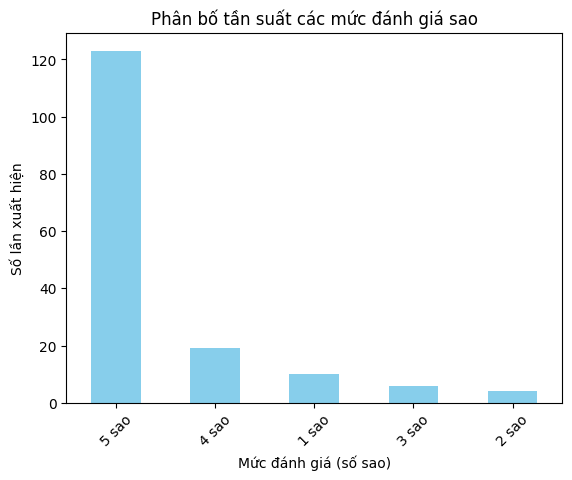

In [64]:
# Đếm số lần mỗi loại sao (1 sao, 2 sao,...) xuất hiện
star_counts = data['Stars'].value_counts()
print(star_counts)

# Vẽ biểu đồ tần suất số sao
star_counts.plot(kind='bar', color='skyblue', title='Phân bố tần suất các mức đánh giá sao')
plt.xlabel('Mức đánh giá (số sao)')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=45)
plt.show()

Số sao trung bình theo năm:
Năm 2017.0: 5.00 sao
Năm 2018.0: 4.48 sao
Năm 2019.0: 4.64 sao
Năm 2020.0: 4.80 sao
Năm 2021.0: 4.79 sao
Năm 2022.0: 4.88 sao
Năm 2023.0: 3.12 sao
Năm 2024.0: 3.00 sao


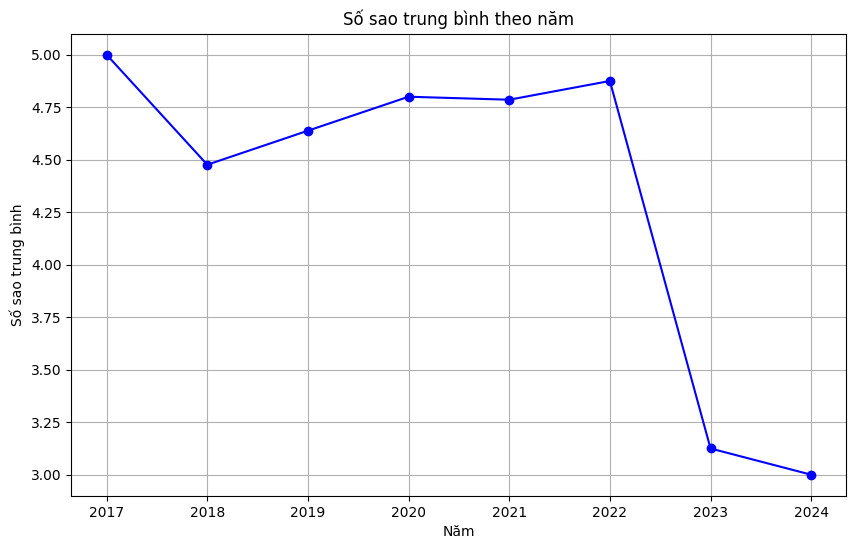

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

# Bước 1: Chuyển đổi cột 'Stars' thành kiểu số
data['Stars_numeric'] = data['Stars'].apply(lambda x: int(x.split()[0]))  # Chỉ lấy số sao

# Bước 2: Chuẩn hóa chuỗi thời gian
data['Date'] = data['Date'].str.replace("một năm trước", "1 năm")  # Thay đổi "một năm trước" thành "1 năm"

# Bước 3: Chuyển đổi chuỗi thời gian thành kiểu datetime
def convert_to_date(date_str):
    if 'tuần' in date_str:
        weeks_ago = int(re.search(r'\d+', date_str).group()) if re.search(r'\d+', date_str) else 0
        return datetime.now() - timedelta(weeks=weeks_ago)  # Tính ngày từ tuần
    elif 'tháng' in date_str:
        months_ago = int(re.search(r'\d+', date_str).group()) if re.search(r'\d+', date_str) else 0
        return datetime.now() - pd.DateOffset(months=months_ago)  # Tính ngày từ tháng
    elif 'năm' in date_str:
        years_ago = int(re.search(r'\d+', date_str).group()) if re.search(r'\d+', date_str) else 0
        return datetime.now() - pd.DateOffset(years=years_ago)  # Tính ngày từ năm
    return pd.NaT  # Trả về NaT nếu không xác định được

data['Date_converted'] = data['Date'].apply(convert_to_date)  # Áp dụng hàm chuyển đổi cho cột Date

# Bước 4: Trích xuất năm và tính số sao trung bình theo năm
data['Year'] = data['Date_converted'].dt.year  # Lấy năm từ cột Date_converted
average_stars_per_year = data.groupby('Year')['Stars_numeric'].mean().reset_index()  # Tính số sao trung bình theo năm

# Bước 5: In số sao trung bình cho mỗi năm
print("Số sao trung bình theo năm:")
for index, row in average_stars_per_year.iterrows():
    print(f"Năm {row['Year']}: {row['Stars_numeric']:.2f} sao")  # Định dạng số sao trung bình với 2 chữ số thập phân

# Bước 6: Vẽ biểu đồ
plt.figure(figsize=(10, 6))  # Kích thước của biểu đồ
plt.plot(average_stars_per_year['Year'], average_stars_per_year['Stars_numeric'], marker='o', color='blue')  # Vẽ đường biểu diễn
plt.title('Số sao trung bình theo năm')  # Tiêu đề biểu đồ
plt.xlabel('Năm')  # Nhãn trục x
plt.ylabel('Số sao trung bình')  # Nhãn trục y
plt.xticks(average_stars_per_year['Year'])  # Hiển thị các năm trên trục x
plt.grid()  # Bật lưới cho biểu đồ
plt.show()  # Hiển thị biểu đồ


# **Model**

In [66]:
data['Content'].value_counts()

,count
Content,
,78
Được rồi,3
Mọi người thân thiện khi Ci Yoga Therapy đến làm workshop tại đây,1
"Văn phòng đẹp, giảng viên hay.",1
Đi đóng bh. Tốn tiền,1
Nơi làm việc tuyệt vời,1
số 1 VN,1
"Ngay trung tâm, sạch sẽ, hiện đại",1
Công ty tài chính chuyên nghiêp,1


### **PhoBert**

In [67]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Tải mô hình và tokenizer PhoBERT đã được fine-tune cho phân tích cảm xúc
checkpoint = "mr4/phobert-base-vi-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Giả định `data` là DataFrame đã được khởi tạo, chứa các cột 'Reviewer', 'Content', và 'Stars'

# Hàm để chuyển đổi dữ liệu thành tensor
def encode_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512)

# Dự đoán cho những dòng có Content không phải là N/A
valid_content = data[data['processed_content'] != '']
if not valid_content.empty:
    inputs = encode_data(valid_content['processed_content'])

    # Dự đoán cảm xúc
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Chuyển đổi xác suất thành nhãn
    predicted_classes = torch.argmax(predictions, dim=1)

    # Thêm kết quả dự đoán vào DataFrame cho Content không phải N/A
    data.loc[data['processed_content'] != '', 'Predicted_Sentiment'] = predicted_classes.numpy()

# Phân loại dựa trên số sao cho những dòng có Content là N/A
def classify_sentiment(star_rating):
    if '5 sao' in star_rating or '4 sao' in star_rating:
        return 2  # Positive
    elif '3 sao' in star_rating:
        return 1  # Neutral
    elif '1 sao' in star_rating or '2 sao' in star_rating:
        return 0  # Negative
    return None

# Áp dụng phân loại cho các dòng có Content là N/A
data.loc[data['processed_content'] == '', 'Predicted_Sentiment'] = data['Stars'].apply(classify_sentiment)

# Áp dụng nhãn cho các giá trị 'Predicted_Sentiment'
data['Sentiment_Label'] = data['Predicted_Sentiment'].apply(lambda x: model.config.id2label[x])

# Hiển thị kết quả
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.expand_frame_repr', False)  # Không ngắt dòng trong DataFrame

print(data[['Content', 'Predicted_Sentiment', 'Sentiment_Label', 'Label']])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                               Content  Predicted_Sentiment Sentiment_Label       Label
0    Mọi người thân thiện khi Ci Yoga Therapy đến l...                  1.0        Tích cực    Tích cực
1    Hợp đồng không được chăm sóc, không có nhân vi...                  0.0        Tiêu cực    Tiêu cực
2    Bạn bè, người thân nói mình mua bảo hiểm không...                  0.0        Tiêu cực    Tiêu cực
3    Manulife ủy quyền cho công ty này giải quyết c...                  0.0        Tiêu cực    Tiêu cực
4    Tôi cần nhân viên giải quyết về quyền lợi của ...                  0.0        Tiêu cực    Tiêu cực
5    Manulife là một công ty bảo hiểm Nuoc ngoài đầ...                  1.0        Tích cực    Tích cực
6    Văn phòng đep, rông rãi, nhân vien nhiet tinh ...                  1.0        Tích cực    Tích cực
7    Văn phòng sạch đẹp, nhân viên lịch sự và văn h...                  1.0        Tích cực    Tích cực
8    Công ty tài chính chuyên nghiêp Quy tụ nhiều b...          

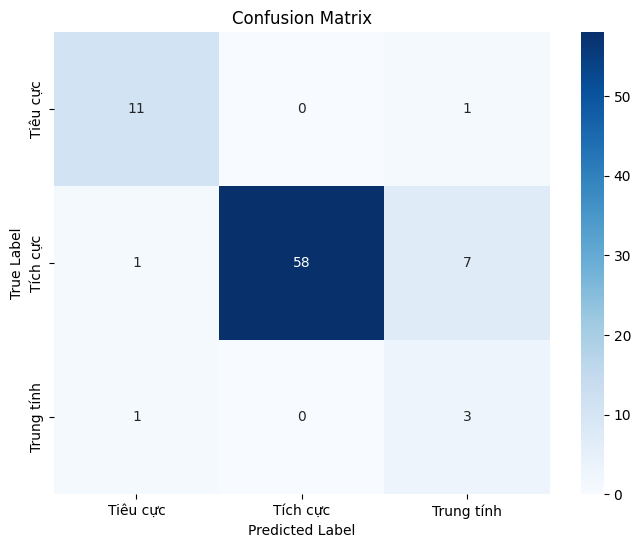

Accuracy: 0.88
Precision: 0.71
Recall: 0.85
F1 Score: 0.74


In [68]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo ánh xạ từ nhãn văn bản sang số
label_mapping = {
    'Tiêu cực': 0,
    'Tích cực': 1,
    'Trung tính': 2}

# Chuyển đổi nhãn thực tế sang dạng số, chỉ lấy những hàng có Content không phải N/A
valid_data = data[data['processed_content'] != '']  # Chỉ lấy những hàng có Content
true_labels = valid_data['Label'].map(label_mapping).values  # Nhãn thực tế chuyển sang số
predicted_labels = valid_data['Sentiment_Label'].map(label_mapping).values  # Nhãn dự đoán từ mô hình

# Tính confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tiêu cực', 'Tích cực', 'Trung tính'],
            yticklabels=['Tiêu cực', 'Tích cực', 'Trung tính'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Tính toán các chỉ số
report = classification_report(true_labels, predicted_labels, output_dict=True)
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# In các chỉ số
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')


In [69]:
# In ra các câu dự đoán sai
incorrect_predictions = valid_data[valid_data['Sentiment_Label'] != valid_data['Label']]
print("Câu dự đoán sai:")
print(incorrect_predictions[['Content', 'Sentiment_Label', 'Label']])

Câu dự đoán sai:
                                               Content Sentiment_Label       Label
13   Văn phòng đẹp và năng lượng. Vote cho Manulife...      Trung tính    Tích cực
18   Van phong dep. Rong rai va thoai mai. Vote cho...      Trung tính    Tích cực
31   Hơi chậm, thủ tục rườm rà, công nghệ cổ lỗ sỉ....      Trung tính    Tiêu cực
40   dich vu chuyen nghiep, phuc vu tan tinh va chu...        Tiêu cực    Tích cực
44   Khung canh, mau sac nhe nhang, nhan vien tan tinh      Trung tính    Tích cực
57                                             số 1 VN      Trung tính    Tích cực
59                                Đi đóng bh. Tốn tiền        Tiêu cực  Trung tính
79                                            Được rồi      Trung tính    Tích cực
137                                           Được rồi      Trung tính    Tích cực
154                                           Được rồi      Trung tính    Tích cực


### **Tinh chỉnh các điều kiện**

In [78]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Tải mô hình và tokenizer PhoBERT đã được fine-tune cho phân tích cảm xúc
checkpoint = "mr4/phobert-base-vi-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Giả định `data` là DataFrame đã được khởi tạo, chứa các cột 'Reviewer', 'Content', và 'Stars'

# Hàm để chuyển đổi dữ liệu thành tensor
def encode_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512)

# Dự đoán cho những dòng có Content không phải là N/A
valid_content = data[data['processed_content'] != '']
if not valid_content.empty:
    inputs = encode_data(valid_content['processed_content'])

    # Dự đoán cảm xúc
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Chuyển đổi xác suất thành nhãn
    predicted_classes = torch.argmax(predictions, dim=1)

    # Thêm kết quả dự đoán vào DataFrame cho Content không phải N/A
    data.loc[data['processed_content'] != '', 'Predicted_Sentiment'] = predicted_classes.numpy()

# Phân loại dựa trên số sao cho những dòng có Content là N/A
def classify_sentiment(star_rating):
    if '5 sao' in star_rating or '4 sao' in star_rating:
        return 2  # Positive
    elif '3 sao' in star_rating:
        return 1  # Neutral
    elif '1 sao' in star_rating or '2 sao' in star_rating:
        return 0  # Negative
    return None

# Áp dụng phân loại cho các dòng có Content là N/A
data.loc[data['processed_content'] == '', 'Predicted_Sentiment'] = data['Stars'].apply(classify_sentiment)
# Đặt nhãn Positive cho các trường hợp "được rồi"
data.loc[data['processed_content'] == "được rồi", 'Predicted_Sentiment'] = 1  # Positive
data.loc[data['processed_content'] == "tốt", 'Predicted_Sentiment'] = 1  # Positive
data.loc[data['processed_content'] == "nhanh", 'Predicted_Sentiment'] = 1  # Positive


# Áp dụng nhãn cho các giá trị 'Predicted_Sentiment'
data['Sentiment_Label'] = data['Predicted_Sentiment'].apply(lambda x: model.config.id2label[x])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


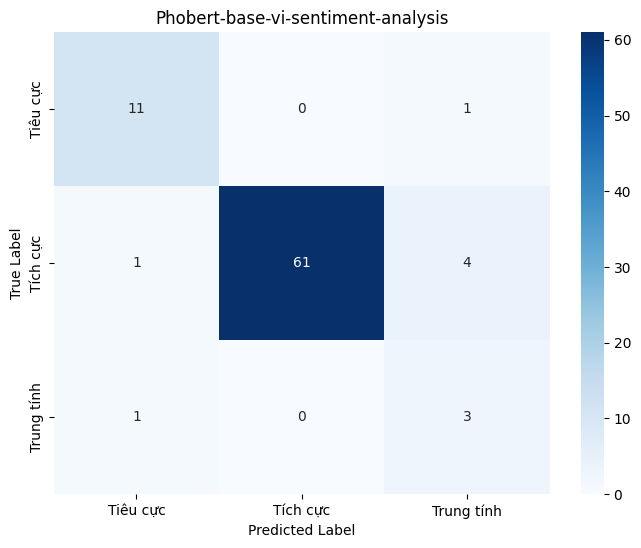

Accuracy: 0.91
Precision: 0.74
Recall: 0.86
F1 Score: 0.78


In [79]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo ánh xạ từ nhãn văn bản sang số
label_mapping = {
    'Tiêu cực': 0,
    'Tích cực': 1,
    'Trung tính': 2}

# Chuyển đổi nhãn thực tế sang dạng số, chỉ lấy những hàng có Content không phải N/A
valid_data = data[data['processed_content'] != '']  # Chỉ lấy những hàng có Content
true_labels = valid_data['Label'].map(label_mapping).values  # Nhãn thực tế chuyển sang số
predicted_labels = valid_data['Sentiment_Label'].map(label_mapping).values  # Nhãn dự đoán từ mô hình

# Tính confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tiêu cực', 'Tích cực', 'Trung tính'],
            yticklabels=['Tiêu cực', 'Tích cực', 'Trung tính'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Phobert-base-vi-sentiment-analysis')
plt.show()

# Tính toán các chỉ số
report = classification_report(true_labels, predicted_labels, output_dict=True)
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# In các chỉ số
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')


In [81]:
# In ra các câu dự đoán sai
incorrect_predictions = valid_data[valid_data['Sentiment_Label'] != valid_data['Label']]
print("Câu dự đoán sai:")
print(incorrect_predictions[['Content','processed_content', 'Sentiment_Label', 'Label']])

Câu dự đoán sai:
                                              Content                                  processed_content Sentiment_Label       Label
13  Văn phòng đẹp và năng lượng. Vote cho Manulife...  văn_phòng đẹp và năng_lượng vote cho manulife ...      Trung tính    Tích cực
18  Van phong dep. Rong rai va thoai mai. Vote cho...  van phong_dep rong rai va thoai mai_vote cho m...      Trung tính    Tích cực
31  Hơi chậm, thủ tục rườm rà, công nghệ cổ lỗ sỉ....  hơi chậm thủ_tục rườm_rà công_nghệ cổ_lỗ sỉ nh...      Trung tính    Tiêu cực
40  dich vu chuyen nghiep, phuc vu tan tinh va chu...  dich vu_chuyen nghiep phuc vu_tan tinh_va chu_dao        Tiêu cực    Tích cực
44  Khung canh, mau sac nhe nhang, nhan vien tan tinh    khung canh mau sac nhe nhang nhan_vien tan_tinh      Trung tính    Tích cực
57                                            số 1 VN                                              số vn      Trung tính    Tích cực
59                               Đi đóng bh. Tốn tiề

###  **Bert-base-for-sentiment**

In [73]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Tải mô hình và tokenizer BERT đã được fine-tune cho phân tích cảm xúc
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'  # Bạn có thể thay đổi nếu cần
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Giả định `data` là DataFrame đã được khởi tạo, chứa các cột 'Reviewer', 'Content', và 'Stars'

# Hàm để chuyển đổi dữ liệu thành tensor
def encode_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512)

# Dự đoán cho những dòng có Content không phải là N/A
valid_content = data[data['processed_content'] != '']
if not valid_content.empty:
    inputs = encode_data(valid_content['processed_content'])

    # Dự đoán cảm xúc
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Chuyển đổi logits thành nhãn
    predicted_classes = torch.argmax(logits, dim=1)

    # Thêm kết quả dự đoán vào DataFrame cho Content không phải N/A
    data.loc[data['processed_content'] != '', 'Predicted_Sentiment'] = predicted_classes.numpy()

# Đặt nhãn Positive cho các trường hợp "được rồi"
data.loc[data['processed_content'] == "được rồi", 'Predicted_Sentiment'] = 3  # Positive

# Phân loại dựa trên số sao cho những dòng có Content là N/A
def classify_sentiment(star_rating):
    if '5 sao' in star_rating or '4 sao' in star_rating:
        return 2  # Positive
    elif '3 sao' in star_rating:
        return 1  # Neutral
    elif '1 sao' in star_rating or '2 sao' in star_rating:
        return 0  # Negative
    return None

# Áp dụng phân loại cho các dòng có Content là N/A
data.loc[data['processed_content'] == '', 'Predicted_Sentiment'] = data['Stars'].apply(classify_sentiment)

# Chuyển đổi giá trị Predicted_Sentiment về 3 nhãn
def map_sentiment(sentiment):
    if sentiment in [0, 1]:  # Rất tiêu cực hoặc tiêu cực
        return 0  # Negative
    elif sentiment == 2:  # Trung lập
        return 1  # Neutral
    elif sentiment in [3, 4]:  # Tích cực hoặc rất tích cực
        return 2  # Positive
    return None

# Áp dụng hàm chuyển đổi cho cột Predicted_Sentiment
data['Predicted_Sentiment'] = data['Predicted_Sentiment'].apply(map_sentiment)

# Áp dụng nhãn cho các giá trị 'Predicted_Sentiment'
data['Sentiment_Label'] = data['Predicted_Sentiment'].map({
    0: "Tiêu cực",
    1: "Trung tính",
    2: "Tích cực"
})

# Hiển thị kết quả
pd.set_option('display.max_rows', None)  # Hiển thị tất cả các hàng
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
pd.set_option('display.expand_frame_repr', False)  # Không ngắt dòng trong DataFrame

print(data[['Content', 'Predicted_Sentiment', 'Sentiment_Label', 'Label']])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


                                               Content  Predicted_Sentiment Sentiment_Label       Label
0    Mọi người thân thiện khi Ci Yoga Therapy đến l...                    2        Tích cực    Tích cực
1    Hợp đồng không được chăm sóc, không có nhân vi...                    0        Tiêu cực    Tiêu cực
2    Bạn bè, người thân nói mình mua bảo hiểm không...                    0        Tiêu cực    Tiêu cực
3    Manulife ủy quyền cho công ty này giải quyết c...                    0        Tiêu cực    Tiêu cực
4    Tôi cần nhân viên giải quyết về quyền lợi của ...                    0        Tiêu cực    Tiêu cực
5    Manulife là một công ty bảo hiểm Nuoc ngoài đầ...                    2        Tích cực    Tích cực
6    Văn phòng đep, rông rãi, nhân vien nhiet tinh ...                    2        Tích cực    Tích cực
7    Văn phòng sạch đẹp, nhân viên lịch sự và văn h...                    2        Tích cực    Tích cực
8    Công ty tài chính chuyên nghiêp Quy tụ nhiều b...          

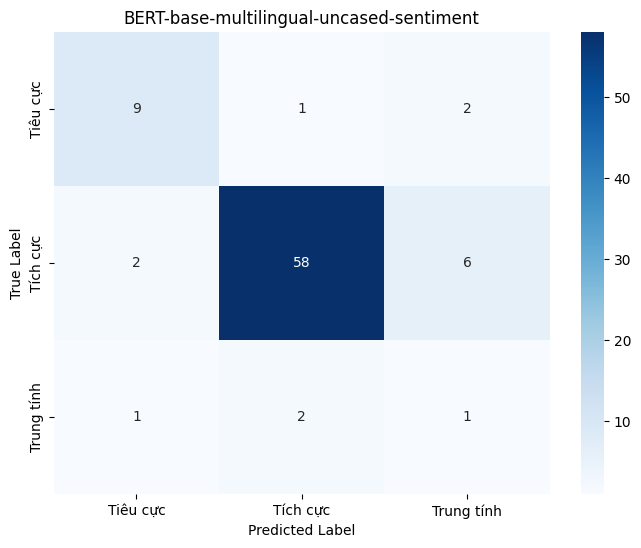

Accuracy: 0.83
Precision: 0.60
Recall: 0.63
F1 Score: 0.61


In [77]:
# Tạo ánh xạ từ nhãn văn bản sang số
label_mapping = {
    'Tiêu cực': 0,
    'Tích cực': 1,
    'Trung tính': 2}

# Chuyển đổi nhãn thực tế sang dạng số, chỉ lấy những hàng có Content không phải N/A
valid_data = data[data['processed_content'] != '']  # Chỉ lấy những hàng có Content
true_labels = valid_data['Label'].map(label_mapping).values  # Nhãn thực tế chuyển sang số
predicted_labels = valid_data['Sentiment_Label'].map(label_mapping).values  # Nhãn dự đoán từ mô hình

# Tính confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tiêu cực', 'Tích cực', 'Trung tính'],
            yticklabels=['Tiêu cực', 'Tích cực', 'Trung tính'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('BERT-base-multilingual-uncased-sentiment')
plt.show()

# Tính toán các chỉ số
report = classification_report(true_labels, predicted_labels, output_dict=True)
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# In các chỉ số
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')

In [75]:
# In ra các câu dự đoán sai
incorrect_predictions = valid_data[valid_data['Sentiment_Label'] != valid_data['Label']]
print("Câu dự đoán sai:")
print(incorrect_predictions[['processed_content', 'Sentiment_Label', 'Label']])

Câu dự đoán sai:
                                    processed_content Sentiment_Label       Label
9              gọi điện ko nghe máy tư_vấn ko niềm nỡ      Trung tính    Tiêu cực
20  nhân_viên tiếp khách_hàng hòa_nhã phục_vụ nhiệ...      Trung tính    Tích cực
22  văn_phòng đẹp tiện_nghi tôi tham_gia hợp_đồng ...      Trung tính    Tích cực
27  chóng tiện_lợi khi cần giải_quyết vấn_đề tài_c...        Tiêu cực    Tích cực
37      gian hiện_đại_năng_động nhân_viên nhiệt_huyết      Trung tính    Tích cực
44    khung canh mau sac nhe nhang nhan_vien tan_tinh        Tiêu cực    Tích cực
56                    ngay trung_tâm sạch_sẽ hiện_đại      Trung tính    Tích cực
57                                              số vn      Trung tính    Tích cực
59                                đi đóng bh tốn tiền        Tiêu cực  Trung tính
63                                  tòa nhà_văn_phòng        Tích cực  Trung tính
68                                             thú_vị      Trung tính    Tích cực

### **Đánh giá**

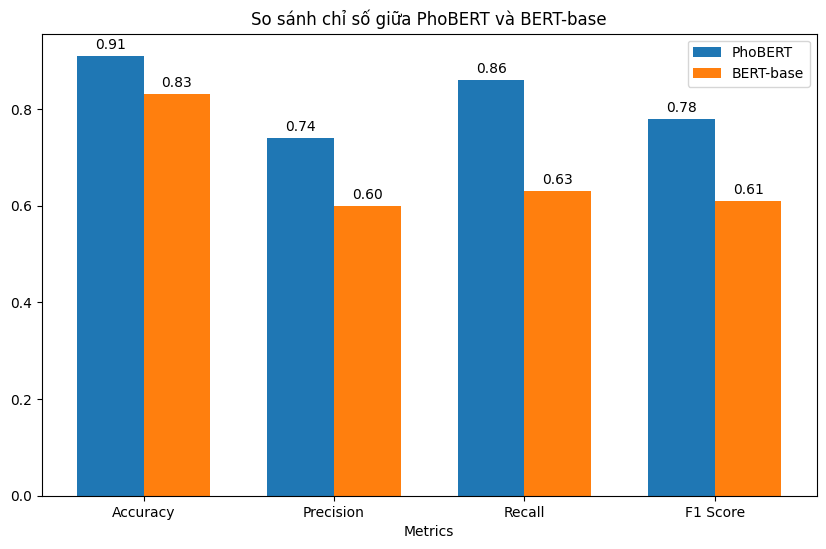

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Các chỉ số của PhoBERT và BERT-base
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
phobert_scores = [0.91, 0.74, 0.86, 0.78]
bert_base_scores = [0.83, 0.60, 0.63, 0.61]

# Tạo vị trí trên trục x
x = np.arange(len(metrics))
width = 0.35  # Độ rộng của các cột

# Vẽ biểu đồ thanh so sánh
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, phobert_scores, width, label='PhoBERT')
bars2 = ax.bar(x + width/2, bert_base_scores, width, label='BERT-base')

# Thêm tiêu đề và nhãn
ax.set_xlabel('Metrics')
ax.set_title('So sánh chỉ số giữa PhoBERT và BERT-base')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị giá trị trên đầu các cột
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Khoảng cách từ đầu cột
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


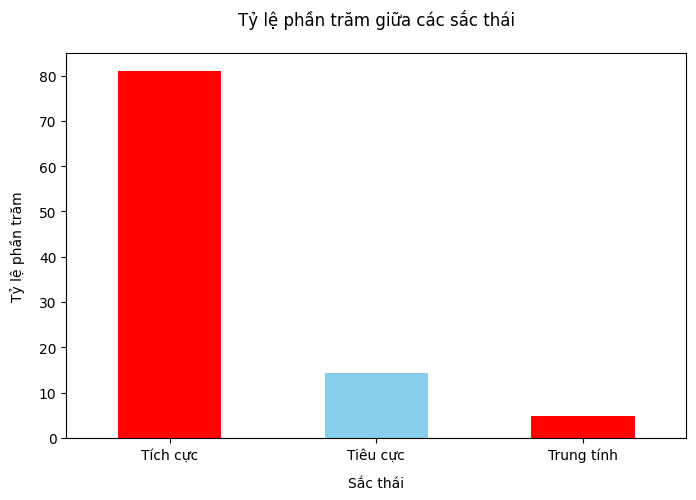

            count       mean        std  min    25%   50%    75%    max
Label                                                                  
Tiêu cực     12.0  44.916667  51.104987  1.0  13.75  29.5  42.75  149.0
Trung tính    4.0   3.500000   1.290994  2.0   2.75   3.5   4.25    5.0
Tích cực     68.0   9.205882   7.008649  1.0   4.00   7.0  14.00   41.0


<ipython-input-76-91cfc5bd27c3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Sentence_Length'] = valid_data['Content'].str.split().str.len()  # Tính độ dài câu


In [76]:
# Bước 1: Tính toán tỷ lệ phần trăm giữa các đánh giá Negative và Positive
valid_data = data[data['processed_content'] != '']  # Chỉ lấy những hàng có Content
sentiment_counts = valid_data['Label'].value_counts()
total_counts = sentiment_counts.sum()
percentage_sentiment = (sentiment_counts / total_counts) * 100

# Bước 2: Vẽ biểu đồ tỷ lệ phần trăm
plt.figure(figsize=(8, 5))
percentage_sentiment.plot(kind='bar', color=['red', 'skyblue'])
plt.title('Tỷ lệ phần trăm giữa các sắc thái', pad=20)  # Bỏ gạch ngang
plt.xlabel('Sắc thái', labelpad=10)  # Bỏ gạch ngang
plt.ylabel('Tỷ lệ phần trăm', labelpad=10)  # Bỏ gạch ngang
plt.xticks(rotation=0)  # Giữ cho nhãn trên trục x thẳng
plt.grid(False)  # Tắt lưới ngang
plt.show()

# Bước 3: Nhóm dữ liệu theo nhãn cảm xúc và tính độ dài câu
valid_data['Sentence_Length'] = valid_data['Content'].str.split().str.len()  # Tính độ dài câu
length_analysis = valid_data.groupby('Label')['Sentence_Length'].describe()

# Hiển thị phân tích độ dài câu
print(length_analysis)